<a href="https://colab.research.google.com/github/zingarelli/alura-challenges-data-science-2022/blob/main/Semana-3/Alura_Challenges_%7C_Data_Science_2022_Semana_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de *Churn Rate* | Alura Voz

Este notebook é a finalização do trabalho feito na [Semana 1](https://github.com/zingarelli/alura-challenges-data-science-2022/tree/main/Semana-1) e na [Semana 2](https://github.com/zingarelli/alura-challenges-data-science-2022/tree/main/Semana-2), cujo objetivo é auxiliar a empresa Alura Voz a reduzir o *Churn Rate* de clientes, isto é, a taxa de evasão de clientes (aqueles que cancelam o plano de Telefone/Internet/Vídeo).

## Resumo das Semanas 1 e 2

A primeira semana foi dedicada a limpar a base de dados fornecida pela Alura Voz e também adaptá-la do inglês para o português. Uma nova coluna também foi criada, com informações sobre o gasto diário aproximado de cada cliente da base. 

A [base original está disponível online](https://raw.githubusercontent.com/sthemonica/alura-voz/main/Dados/Telco-Customer-Churn.json), bem como seu [dicionário de dados](https://github.com/sthemonica/alura-voz/blob/main/dicionario.md). 

Na segunda semana, foi feita a análise gráfica da base, visualizando o *target*, no caso, a coluna de Churn (chamada de `cancelou_plano`), e cruzando seus dados com os de outras colunas da base, procurando buscar relações e tendências que pudessem ver vistas visualmente. As conclusões baseadas nessa análise gráfica serão utilizadas nesta parte final do projeto.

## Semana 3 - Modelagem

Para esta semana final, serão criados dois modelos de Machine Learning para classificar os clientes entre aqueles que talvez venham a cancelar seus planos. As features que serão utilizadas nos modelos são baseadas nas conclusões obtidas na Semana 2. Por exemplo: foi visto que os cancelamentos se concentravam em clientes novos, bem como em planos mais caros. Dentre outras relações observadas.

Há também uma análise de balanceamento do target e de duas estratégias para tratar o desbalanceamento: oversampling (com SMOTE) e undersampling (com Near Miss).

Os dois modelos serão comparados com métricas de Acurácia, Precisão, Recall e F1, além de uma análise visual com Matriz de Confusão. Para o modelo que se sair melhor, será feita uma otimização dos parâmetros, em busca de melhoria nas métricas. 

#Configurações e imports

In [41]:
# biblioteca para balanceamento da target Churn
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# para o One-Hot Encoding das variáveis categóricas
from sklearn.preprocessing import OneHotEncoder

# para balanceamento do target
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# para criação e validação dos modelos de machine learn
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# semente para garantir a replicabilidade do código
SEED = 12

pd.set_option('display.max_columns', 22)

In [43]:
# leitura da base tratada na Semana 1
df = pd.read_csv('https://raw.githubusercontent.com/zingarelli/alura-challenges-data-science-2022/main/Semana-1/analise_semana_1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cliente_ID                      7043 non-null   object 
 1   cancelou_plano                  7043 non-null   object 
 2   genero                          7043 non-null   object 
 3   maior_65_anos                   7043 non-null   int64  
 4   possui_companheiro_companheira  7043 non-null   object 
 5   possui_dependentes              7043 non-null   object 
 6   meses_contrato                  7043 non-null   int64  
 7   assina_telefone                 7043 non-null   object 
 8   multiplas_linhas_telefonicas    7043 non-null   object 
 9   tipo_assinatura_internet        7043 non-null   object 
 10  adicional_seguranca_online      7043 non-null   object 
 11  adicional_backup_online         7043 non-null   object 
 12  adicional_protecao_dispositivo  70

# Encoding das variáveis categóricas

Existem muitas colunas na base com dtype `object` (colunas categóricas). Elas precisarão ser alteradas para valores numéricos, de modo a poderem ser utilizadas nos modelos de Machine Learning. 

Há diferentes formas de se fazer isso. Escolhi a mais simples, que seria o Label Encoding. Posteriormente, decidi testar o One-Hot Encoding, mas tive que adaptar parte do código para que ele rodasse.

## Label Encoding

Esse método foi utilizado e testado na Semana 2, então decidi replicá-lo para esta semana.

In [44]:
# função que transforma os valores categóricos de uma coluna em valores numéricos
def label_encoding(categorical_col):
  # altera o tipo de "object" para o tipo "category"
  encode = categorical_col.astype('category')

  # atribui a cada categoria um valor numérico diferente
  return encode.cat.codes

In [45]:
# copiando a base de dados para ter um backup da base original
df_encoded = df.copy()

# colunas categóricas (sem o "cliente_ID", pois não será utilizada)
cat_columns = ['cancelou_plano', 'genero', 'possui_companheiro_companheira', 
               'possui_dependentes', 'assina_telefone', 'multiplas_linhas_telefonicas',
               'tipo_assinatura_internet', 'adicional_seguranca_online',
               'adicional_backup_online', 'adicional_protecao_dispositivo',
               'adicional_suporte_VIP', 'assina_TV_cabo', 'assina_streaming_filmes',
               'plano_contratado', 'fatura_online', 'forma_pagamento']

# aplicando o label encoding
for col in cat_columns:
  df_encoded[col] = label_encoding(df_encoded[col])

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cliente_ID                      7043 non-null   object 
 1   cancelou_plano                  7043 non-null   int8   
 2   genero                          7043 non-null   int8   
 3   maior_65_anos                   7043 non-null   int64  
 4   possui_companheiro_companheira  7043 non-null   int8   
 5   possui_dependentes              7043 non-null   int8   
 6   meses_contrato                  7043 non-null   int64  
 7   assina_telefone                 7043 non-null   int8   
 8   multiplas_linhas_telefonicas    7043 non-null   int8   
 9   tipo_assinatura_internet        7043 non-null   int8   
 10  adicional_seguranca_online      7043 non-null   int8   
 11  adicional_backup_online         7043 non-null   int8   
 12  adicional_protecao_dispositivo  70

## One-Hot Encoding

Rever curso Kaggle: https://www.kaggle.com/code/alexisbcook/categorical-variables


**Atenção!**

Essa parte do código foi feita após a criação dos modelos e métricas, então sua aplicação não está bonita no código. Infelizmente, seria necessário refatorar muita coisa para ela ser aplicada. 

TO DO: Refatorar o projeto para poder escolher entre os dois encodings (label encoding ou OH encoding)

No caso do One-Hot Encoding, eu criei uma função, a ser chamada no momento de utilização dos modelos, quando as features que farão parte do modelo já foram escolhidas. O motivo disso é que o One-Hot Encoding cria colunas a mais e assim se perde o nome de cada coluna (cada coluna ganha um valor numérico sequencial). Não sei se existe algum parâmetro que poderia alterar isso e criar nomes mais representativos para as colunas. -> existe o `get_dummies()`, que faz algo semelhante sem perder o significado do nome das colunas: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

In [46]:
def OH_encode(data, features):
  # criando o encoder
  OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

  # criando um dataframe com o One-Hot Encoding aplicado
  OH_columns = pd.DataFrame(OH_encoder.fit_transform(data[features]))

  # copiando o dataframe sem as colunas que foram codificadas
  df_copy = data.drop(features, axis=1)

  # concatenando as colunas codificadas
  return pd.concat([df_copy, OH_columns], axis=1)

In [47]:
# teste da função
# features = ['genero', 'maior_65_anos', 'plano_contratado', 'fatura_online', 'forma_pagamento']
# df_OH_encoded = OH_encode(df, features)
# print(df_OH_encoded.shape)
# df_OH_encoded.head()

# Verificar se a variável target `Churn` está desbalanceada

Ver artigo: https://www.alura.com.br/artigos/lidando-com-desbalanceamento-dados

Ver documentação: https://imbalanced-learn.org/stable/introduction.html

Ver treinamento da Sthe: https://cursos.alura.com.br/course/modelos-preditivos-dados-deteccao-fraude/task/106523

In [48]:
# armazenando os dados de cancelamento do plano em uma variável chamada churn
churn = df_encoded['cancelou_plano']

# separando entre clientes que estão ativos e aqueles que cancelaram o plano (former_customer)
# lembrando que o "Sim" significa que o cliente cancelou o plano
active_customers = (churn == 0).sum()
former_customers = (churn == 1).sum()
total_customers = len(churn)

print(f'Total de planos: {total_customers}')
print(f'Planos ativos: {active_customers}, {round(active_customers/total_customers*100, 2)}% do total')
print(f'Planos cancelados: {former_customers}, {round(former_customers/total_customers*100, 2)}% do total')

Total de planos: 7043
Planos ativos: 5174, 73.46% do total
Planos cancelados: 1869, 26.54% do total


Cerca de pouco mais de **um quarto da base** é formado por pessoas que **cancelaram** o plano (valor `1` na base), e o restante, de pessoas que mantiveram o plano (valor `0` na base). Isso faz com que a variável **target esteja desbalanceada**, o que pode **prejudicar** na criação dos modelos de Machine Learning. 

Desse modo, antes de criar os modelos é necessário fazer um balanceamento do target. 

Isso pode ser feito por meio do **oversampling**, isto é, criação de **novos dados (sintéticos) para aumentar** a quantidade de valores 1 na variável `cancelou_plano`, ou por meio do **undersampling**, isto é, selecionando na base **apenas alguns de registros** que possuam o valor 0 em `cancelou_plano`. Em ambas as estratégias, o objetivo e ter uma quantidade equivalente de registros com os valores 0 e 1.

## Estratégia de balanceamento 1: Oversampling
Utilizando o algoritmo SMOTE (KNN) para cópia de dados

In [49]:
# aplicando o random_state para garantir a replicabilidade do código
smote = SMOTE(random_state = SEED)

# separando as variáveis de treino e target
# client_ID também foi removida, pois não será necessária
x = df_encoded.drop(['cancelou_plano', 'cliente_ID'], axis=1)
y = df_encoded['cancelou_plano']  

# aplicando a SMOTE e salvando os novos dados criados
x_oversmp, y_oversmp = smote.fit_resample(x, y)

In [50]:
# criando a base balanceada com oversampling
df_oversmp = pd.concat([y_oversmp, x_oversmp], axis=1)
df_oversmp.sample(5)

,cancelou_plano,genero,maior_65_anos,possui_companheiro_companheira,possui_dependentes,meses_contrato,assina_telefone,multiplas_linhas_telefonicas,tipo_assinatura_internet,adicional_seguranca_online,adicional_backup_online,adicional_protecao_dispositivo,adicional_suporte_VIP,assina_TV_cabo,assina_streaming_filmes,plano_contratado,fatura_online,forma_pagamento,gasto_diario,gasto_mensal,gasto_total
3157,0,1,1,1,0,25,1,0,1,0,2,2,0,0,2,1,0,3,2.950000,88.400000,2191.150000
9456,1,0,0,0,0,41,0,0,0,0,0,1,0,0,0,0,0,0,0.958492,28.860518,1127.644969
10008,1,0,0,1,0,20,1,0,1,0,0,0,0,0,0,1,1,1,2.317583,69.574734,1473.413711
8315,1,0,0,0,0,1,1,0,0,2,1,0,0,0,0,1,1,1,1.817428,54.501881,54.501881
3656,0,1,0,1,0,72,1,2,1,0,2,2,2,2,2,2,1,3,3.620000,108.500000,8003.800000


In [51]:
# verificando o balanceamento e comparando com a base original
print('Tamanho base original: ', df.shape)
print('Tamanho base com oversample: ', df_oversmp.shape)
print(f'Foram criados {df_oversmp.shape[0] - df.shape[0]} registros sintéticos.')
print('Valores de churn:')
print(df_oversmp['cancelou_plano'].value_counts())

Tamanho base original:  (7043, 22)
Tamanho base com oversample:  (10348, 21)
Foram criados 3305 registros sintéticos.
Valores de churn:
0    5174
1    5174
Name: cancelou_plano, dtype: int64


Com isso, foram adicionados 3305 registros com dados sintéticos, um **incremento de 47%** de registros na base de dados. Não sei se isso é bom ou ruim (minha intuição me diz que é meio preocupante).

##Estratégia de balanceamento 2: Undersampling

Utilizando o método NearMiss para seleção dos valores

In [52]:
# utilizando o método com os parâmetros padrões
nm = NearMiss()

# separando target das outras features
# client_ID também foi removida, pois não será necessária
x = df_encoded.drop(['cancelou_plano', 'cliente_ID'], axis=1)
y = df_encoded['cancelou_plano']

x_undersmp, y_undersmp = nm.fit_resample(x, y)

In [53]:
# criando a base balanceada com undersampling
df_undersmp = pd.concat([y_undersmp, x_undersmp], axis=1)
df_undersmp.sample(5)

,cancelou_plano,genero,maior_65_anos,possui_companheiro_companheira,possui_dependentes,meses_contrato,assina_telefone,multiplas_linhas_telefonicas,tipo_assinatura_internet,adicional_seguranca_online,adicional_backup_online,adicional_protecao_dispositivo,adicional_suporte_VIP,assina_TV_cabo,assina_streaming_filmes,plano_contratado,fatura_online,forma_pagamento,gasto_diario,gasto_mensal,gasto_total
2230,1,0,0,0,0,66,1,0,1,0,2,2,0,2,2,1,0,1,3.32,99.50,6710.50
473,0,0,0,1,1,10,1,0,2,1,1,1,1,1,1,1,1,0,0.67,20.05,218.50
2629,1,0,1,1,0,29,1,2,1,0,0,2,0,2,2,1,1,1,3.28,98.50,3004.15
3701,1,1,0,0,0,39,1,2,1,0,2,2,0,2,2,1,1,1,3.45,103.45,3994.45
1298,0,0,0,0,0,17,1,0,0,2,2,0,0,0,0,2,0,2,1.87,56.10,946.95


In [54]:
# verificando o balanceamento e comparando com a base original
print('Tamanho base original: ', df.shape)
print('Tamanho base com undersample: ', df_undersmp.shape)
print(f'Foram removidos {df.shape[0] - df_undersmp.shape[0]} registros.')
print('Valores de churn:')
print(df_undersmp['cancelou_plano'].value_counts())

Tamanho base original:  (7043, 22)
Tamanho base com undersample:  (3738, 21)
Foram removidos 3305 registros.
Valores de churn:
0    1869
1    1869
Name: cancelou_plano, dtype: int64


Com isso, 3305 registros foram removidos para criar a base a ser usada pelo modelo. A base agora tem **53% do tamanho original**. Do mesmo modo como o oversampling, minha intuição também me diz que isso é meio preocupante. 

Será necessário **testar as duas estratégias**, over e undersampling, nos modelos de Machine Learning para verificar qual delas **produz melhores métricas**.

# Criação dos modelos de Machine Learning

Ver treinamento Sthe: https://cursos.alura.com.br/course/modelos-preditivos-dados-deteccao-fraude/task/106629

Rever curso Kaggle: 
> https://www.kaggle.com/code/dansbecker/your-first-machine-learning-model, 

> https://www.kaggle.com/code/dansbecker/random-forests

Ver código criado na Housing Prices Competition do Kaggle (precisa estar logado): https://www.kaggle.com/code/zingarelli/ml-competitions-first-own-submission

Aula de ML da Imersão Dados 4 da Alura (talvez não esteja mais disponível): https://www.youtube.com/watch?v=8VsqXXXHp8U

Criei algumas funções para etapas que serão utilizadas pelos dois modelos, para evitar repetição de código. Uma função para retornar os dados de treino e teste, e outra para calcular e apresentar os resultados de métricas e a Matriz de Confusão.

In [55]:
# função que separa e retorna os dados de treino e teste, baseado nas features escolhidas
def get_training_data(data, features):
  # separando target e features
  y = data['cancelou_plano']
  X = data[features]  

  # retorna os dados de treino e validação (por padrão 25% dos dados para validação)
  return train_test_split(X, y, random_state=SEED)

In [56]:
# função que imprime as métricas de acurácia, precisão, recall (sensibilidade), F1
# e também faz o plot da matriz de confusão
def get_metrics(test, prediction):
  # métricas de validação do modelo criado
  print('-'*40 + '\nResultados do Modelo\n' + '-'*40)
  print('Acurácia (acerto geral): ', metrics.accuracy_score(test, prediction))
  print('Precisão (acerto de quem cancelou o plano, dentre os positivos reais): ', metrics.precision_score(test, prediction))
  print('Recall (acerto de quem cancelou o plano, dentre todos os positivos): ', metrics.recall_score(test, prediction)) 
  print('F1 (média harmônica precisão e recall): ', metrics.f1_score(test, prediction))

  # plot da matriz de confusão
  cm = metrics.confusion_matrix(test, prediction)
  disp = metrics.ConfusionMatrixDisplay(cm)
  disp.plot()

## Modelo 1: Random Forest

Ver documentação: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Ver treinamento Sthe: https://cursos.alura.com.br/course/modelos-preditivos-dados-deteccao-fraude/task/106526

In [57]:
# função para criar o modelo e aplicar algumas métricas
# data: base de dados
# features: colunas a serem consideradas para o treino
# n_trees: número de árvores da floresta
# depth: faz a "poda" das árvores após atingir a profundidade (para evitar overfitting)
def random_forest_model(data, features, n_trees=100, depth=5):  
  # separando os dados de treino e validação
  X_train, X_test, y_train, y_test = get_training_data(data, features)

  # criando o modelo e predizendo os resultados de teste
  rf = RandomForestClassifier(random_state=SEED, n_estimators=n_trees, max_depth=depth)
  rf.fit(X_train, y_train)
  y_pred = rf.predict(X_test)

  # print das métricas e matriz de confusão
  get_metrics(y_test, y_pred)

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7572477773482799
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7423398328690808
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.8051359516616314
F1 (média harmônica precisão e recall):  0.772463768115942


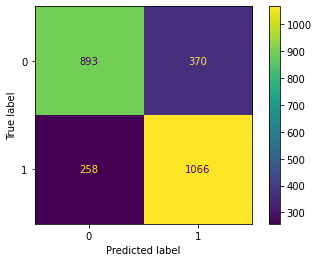

In [58]:
# escolhendo algumas colunas para testar o modelo
features = ['genero', 'maior_65_anos', 'gasto_mensal', 'meses_contrato']
random_forest_model(df_oversmp, features)

## Modelo 2: SVC (Support Vector Classification)

Ver documentação: 

> https://scikit-learn.org/stable/modules/svm.html#

> https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

TO DO: verificar como alterar os parâmetros para otimizar o modelo

In [59]:
# função para criar o modelo e aplicar algumas métricas
def SVC_model(data, features):
  # separando os dados de treino e validação
  X_train, X_test, y_train, y_test = get_training_data(data, features)

  # criando o modelo e predizendo os resultados de teste
  clf = SVC(random_state=SEED)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  # print das métricas e matriz de confusão
  get_metrics(y_test, y_pred)

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7398531117124082
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7306874557051737
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.7787009063444109
F1 (média harmônica precisão e recall):  0.7539305301645339


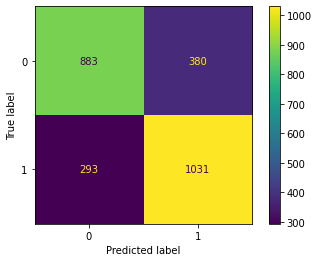

In [60]:
# escolhendo algumas colunas para testar o modelo
features = ['genero', 'maior_65_anos', 'gasto_mensal', 'meses_contrato']
SVC_model(df_oversmp, features)

# Análise dos modelos

Com os modelos criados, irei verificar como performam para diferentes cenários:

1.   Base de dados com Oversampling
2.   Base de dados com Undersampling
3.   Base de dados original (desbalanceada)

Nos três cenários, a base foi codificada utilizando o **Label Encoding**. 

Optei por aplicar também o One-Hot Encoding, porém fiz isso somente após grande parte do projeto já estar feita baseada no Label Encoding. Padronizar o projeto para poder escolher entre os dois tipos de codificação envolveria refatoração de muito código, o que não vou conseguir fazer para entregar o desafio dentro do prazo. Apesar disso, também testei os dois modelos aplicando o One-Hot Encoding + Oversampling e os resultados são mostrados em uma [seção a parte](#scrollTo=sbX-hMxbUhO5).




## Escolha das features
Na Semana 2, foi possível analisar algumas variáveis que de alguma forma mostravam uma influência quando comparadas com a variável Churn (`cancelou_plano`). São elas:

*   Gasto mensal;
*   Senioridade (idade acima ou abaixo de 65 anos);
*   Gênero (especificamente para a faixa de 70 a 110 dólares de gastos mensais);
*   Meses de contrato;
*   Pessoas com ou sem dependentes;
*   Tipo de plano contratado.

Irei utilizar essas variáveis como as features para o treinamento dos modelos.



In [61]:
features = ['gasto_mensal', 'maior_65_anos', 'genero', 'meses_contrato', 'possui_dependentes', 'plano_contratado']

## Avaliação com Oversampling

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7812137611132586
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7483617300131061
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.8625377643504532
F1 (média harmônica precisão e recall):  0.8014035087719299


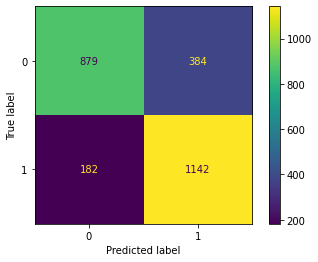

In [62]:
# Random Forest
random_forest_model(df_oversmp, features)

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7413993042133745
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7279053583855254
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.7900302114803626
F1 (média harmônica precisão e recall):  0.7576964867801521


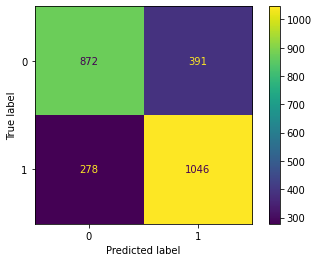

In [63]:
# SVC
SVC_model(df_oversmp, features)

O modelo de Random Forest apresentou os melhores valores nas quatro métricas utilizadas, apesar de as diferenças na comparação entre as métricas estar na segunda casa decimal. 

Na matriz de confusão, o Random Forest também teve mais acertos e errou menos nos Falsos Positivos/Negativos, se destacando mais nos acertos de Verdadeiros Positivos (4º quadrante) e na menor quantidade de Falsos Negativos (3º quadrante). Nos outros dois quadrantes, os resultados foram bem próximos nos dois modelos.

Neste caso, o **Random Forest** foi o que teve a **melhor performance**, apesar de não ter sido uma diferença tão significativa.

## Avaliação com Undersampling

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.6588235294117647
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.6457242582897034
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.7613168724279835
F1 (média harmônica precisão e recall):  0.6987724268177526


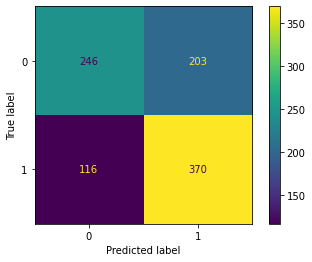

In [64]:
# Random Forest
random_forest_model(df_undersmp, features)

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.6598930481283423
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.6615384615384615
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.7078189300411523
F1 (média harmônica precisão e recall):  0.68389662027833


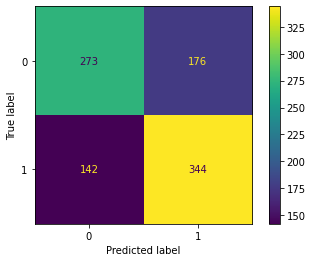

In [65]:
# SVC
SVC_model(df_undersmp, features)

Em ambos os modelos, as **métricas foram piores do que as obtidas com a base com oversampling**. Isso provavelmente aconteceu porque a **quantidade de dados** para o treinamento dos modelos foi **consideravelmente diminuída** (cerca de 53% do tamanho original).

A comparação das métricas entre os dois modelos mostraram resultados parecidos, com pouca diferença, sendo que o Recall foi o único que teve alguma diferença maior (0,76 para o Random Forest e 0,71 para o SVC); ainda assim, baixa.

A matriz de confusão também trouxe pouca diferença entre os dois modelos, sendo que nos quadrantes 1 e 2 o SVC foi melhor, e nos quadrantes 3 e 4, o Random Forest foi melhor. 

Neste caso, **não houve diferença significativa** entre os dois modelos. 

## Avaliação com a base desbalanceada

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7967064168086314
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7116788321167883
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.41139240506329117
F1 (média harmônica precisão e recall):  0.5213903743315508


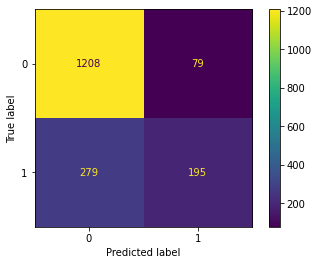

In [66]:
# Random Forest
random_forest_model(df_encoded, features)

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7915956842703009
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.708171206225681
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.38396624472573837
F1 (média harmônica precisão e recall):  0.49794801641586867


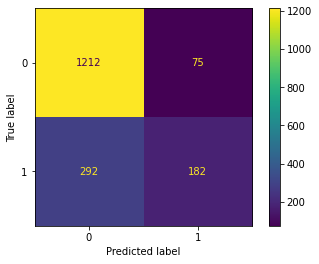

In [67]:
# SVC
SVC_model(df_encoded, features)

Fiz esta análise para verificar o perigo de uma base desbalanceada.

Em ambos os modelos, a acurácia foi até um pouco mais alta do que com a base com oversampling, com a precisão também obtendo valores semelhantes. No entanto, o problema aparece nas métricas de **Recall e F1**, que foram **muito mais baixas** na base de dados desbalanceada (0,41 e 0,52 no Random Forest e 0,38 e 0,50 no SVC, respectivamente). Ou seja, os modelos acertam bem quando preveem se uma pessoa não cancela o plano, mas erram muito ao prever se a pessoa irá cancelar o plano. Isso é **reflexo da base desbalanceada**, cujo apenas 1/4 dos registros é de pessoas que cancelaram o plano.

A comparação das métricas e da matriz de confusão entre os dois modelos apresentou resultados parecidos, então, para este caso, n**ão houve diferença significativa** entre os dois modelos.

## Conclusão

A **base com oversampling** teve as melhores métricas e a apresentou a melhor matriz de confusão. 

Levando em conta esta base, bem como as features escolhidas e a aplicação dos modelos com os parâmetros padrões, dentre os dois modelos, o **Random Forest** foi melhor, apesar de a diferença não ter sido tão gritante.

## Teste com o One-Hot Encoding

Para finalizar as análises, segue o teste da base feita com One-Hot Encoding, aplicando também a técnica do oversampling.

Sim, essa parte está bem hardcoded e muito feia... :(

In [79]:
# colunas categóricas que irão para o modelo
cat_features = ['genero', 'maior_65_anos', 'possui_dependentes', 'plano_contratado']

# aplicando o One-Hot Encoding
df_OH_encoded = OH_encode(df, cat_features)

# alterando o target para 0 (não cancelou) ou 1 (cancelou)
df_OH_encoded['cancelou_plano'] = df_OH_encoded['cancelou_plano'].apply(lambda x : 1 if x == 'Sim' else 0)

# verificando a base e as novas colunas
df_OH_encoded.head()

,cliente_ID,cancelou_plano,possui_companheiro_companheira,meses_contrato,assina_telefone,multiplas_linhas_telefonicas,tipo_assinatura_internet,adicional_seguranca_online,adicional_backup_online,adicional_protecao_dispositivo,adicional_suporte_VIP,...,gasto_mensal,gasto_total,0,1,2,3,4,5,6,7,8
0,0002-ORFBO,0,Sim,9,Sim,Nao,Cabo,Nao,Sim,Nao,Sim,...,65.6,593.30,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0003-MKNFE,0,Nao,9,Sim,Sim,Cabo,Nao,Nao,Nao,Nao,...,59.9,542.40,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0004-TLHLJ,1,Nao,4,Sim,Nao,Fibra,Nao,Nao,Sim,Nao,...,73.9,280.85,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0011-IGKFF,1,Sim,13,Sim,Nao,Fibra,Nao,Sim,Sim,Nao,...,98.0,1237.85,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,0013-EXCHZ,1,Sim,3,Sim,Nao,Fibra,Nao,Nao,Nao,Sim,...,83.9,267.40,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7939698492462312
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7476518472135254
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.9018126888217523
F1 (média harmônica precisão e recall):  0.8175282437521398


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7406262079628914
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7259515570934256
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.7922960725075529
F1 (média harmônica precisão e recall):  0.7576742506319971


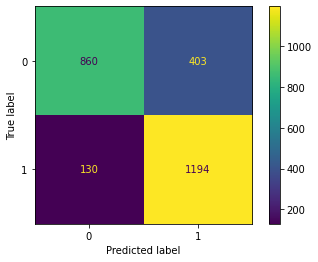

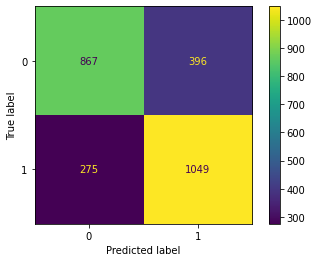

In [80]:
# o One-Hot Encoding criou novas colunas, então preciso alterar as features
features = ['gasto_mensal', 'meses_contrato', 0, 1, 2, 3, 4, 5, 6, 7, 8]

# fazendo o oversampling
smote = SMOTE(random_state = SEED)
x = df_OH_encoded[features]
y = df_OH_encoded['cancelou_plano']
x_oversmp, y_oversmp = smote.fit_resample(x, y) # gera um warning que em futuras versões poderá ser um erro
df_OH_oversmp = pd.concat([y_oversmp, x_oversmp], axis=1)

# testando os modelos
# também gera um warning que em futuras versões poderá ser um erro
random_forest_model(df_OH_oversmp, features)
SVC_model(df_OH_oversmp, features)

Os resultados dos modelos utilizando a base de dados com One-Hot Encoding + Oversampling se mostraram também muito bons. 

Em comparação com a base com Label Enconding + Oversampling, as métricas para o **Random Forest** foram até **maiores** para o caso do One-Hot Encoding, com **destaque para o Recall**, que atingiu **0,90** (contra 0,86 na base com Label Encoding), ou seja, ele conseguiu acertar mais e melhor quem irá cancelar o plano. No caso do SVC, os resultados foram semelhantes para ambos os encoding.

Como essa parte do One-Hot Encoding foi **feita com pressa**, pode ser que eu tenha errado em algum passo, pois copiei e colei muito código. Por esse motivo, vou optar por **manter os dados com o Label Encoding** para a otimização do modelo do Random Forest.

# Otimização do Random Forest

Escolhido o Random Forest como modelo e a base com label encoding e oversampling, irei fazer alguns testes alterando parâmetros do modelo e também features da base para verificar se as métricas melhoram

## Teste do modelo com todas as colunas da Base

Apenas de curiosidade, vou verificar como o modelo se sai quando utilizo todas as colunas como features.

In [70]:
# verificando as colunas (cliente_ID foi removida durante o oversampling)
df_oversmp.columns.values

array(['cancelou_plano', 'genero', 'maior_65_anos',
       'possui_companheiro_companheira', 'possui_dependentes',
       'meses_contrato', 'assina_telefone',
       'multiplas_linhas_telefonicas', 'tipo_assinatura_internet',
       'adicional_seguranca_online', 'adicional_backup_online',
       'adicional_protecao_dispositivo', 'adicional_suporte_VIP',
       'assina_TV_cabo', 'assina_streaming_filmes', 'plano_contratado',
       'fatura_online', 'forma_pagamento', 'gasto_diario', 'gasto_mensal',
       'gasto_total'], dtype=object)

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7947429454967143
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.776692254012561
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.8406344410876133
F1 (média harmônica precisão e recall):  0.8073993471164309


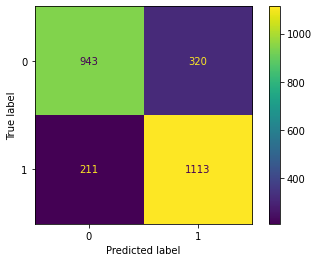

In [71]:
# aplicando o modelo com todas as colunas, menos a target, que é 'cancelou_plano'
features = df_oversmp.drop('cancelou_plano', axis=1).columns.values
random_forest_model(df_oversmp, features)

O modelo teve uma leve melhora de performance em todas as métricas, menos no Recall, onde foi levemente pior. Então acredito que as [features selecionadas anteriormente](#scrollTo=Rm_LSvdxQ8Pa) estão adequadas. 

Listo elas abaixo novamente, que serão utilizadas nos próximos testes.

In [81]:
# features escolhidas para o modelo
features = ['gasto_mensal', 'maior_65_anos', 'genero', 'meses_contrato', 'possui_dependentes', 'plano_contratado']

## Avaliação dos parâmetros do modelo

Irei testar o modelo com diferentes valores para os parâmetros `n_trees` e `depth`, que foram criados na função do modelo e são baseados nos parâmetros `n_estimators`, `max_depth`. O objetivo é avaliar qual seria o melhor valor para estes dois parâmetros, tendo em vista melhores resultados nas métricas.

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7816003092385002
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7495069033530573
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.8610271903323263
F1 (média harmônica precisão e recall):  0.8014059753954306
----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7812137611132586
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7483617300131061
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.8625377643504532
F1 (média harmônica precisão e recall):  0.8014035087719299
----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7781213761113258
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.74

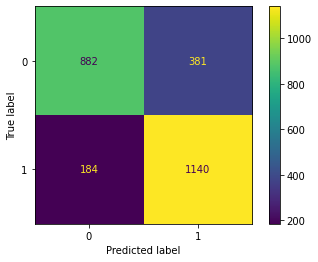

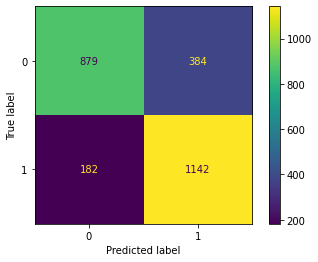

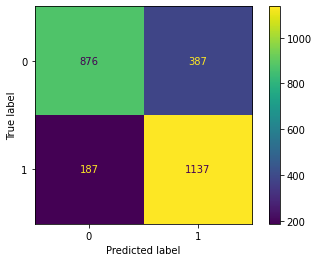

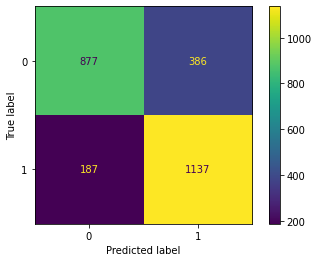

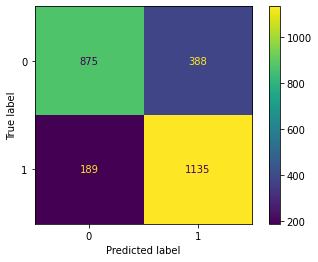

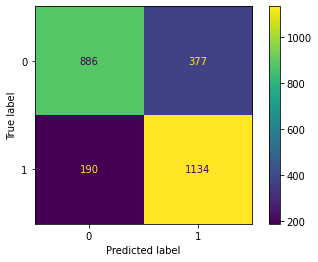

In [73]:
# testando a quantidade de árvores no modelo
n_trees = [50, 100, 150, 200, 250, 500] #500 na última iteração só para teste de estresse
for trees in n_trees:
  random_forest_model(df_oversmp, features, trees)

Os resultados das métricas para os diferentes valores de `n_trees` se mostraram **semelhantes**. As diferenças aconteciam na 2ª ou 3ª casa decimal. 

Os resultados em **precisão e F1 foram melhores para 100 árvores** (que é o padrão do modelo), então **irei manter o valor padrão para `n_trees`**.

In [74]:
# valor selecionado para a quantidade de árvores (já é o padrão do modelo no sklearn)
n_trees = 100

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7812137611132586
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7483617300131061
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.8625377643504532
F1 (média harmônica precisão e recall):  0.8014035087719299
----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7962891379976808
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7784765897973445
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.8413897280966768
F1 (média harmônica precisão e recall):  0.8087114337568058
----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7819868573637417
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.77

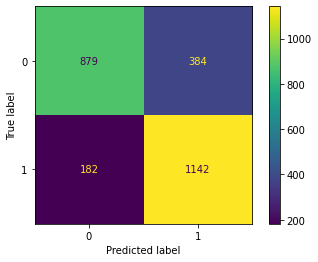

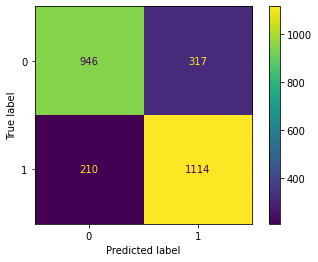

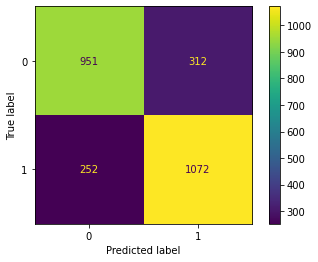

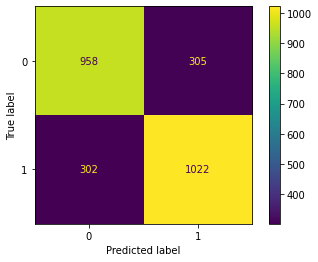

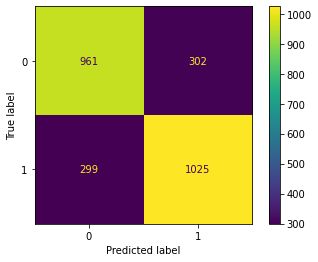

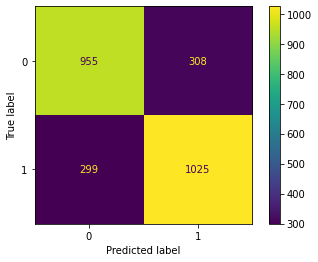

In [75]:
# testando a profundidade das árvores no modelo
max_depth = [5, 10, 15, 20, 25, 30]
for depth in max_depth:
  random_forest_model(df_oversmp, features, n_trees, depth)

Após a **profundidade 10**, os valores das métricas foram **caindo**, com exceção da precisão, que foi melhorando. 

Comparando as matrizes de confusão, é possível notar que essa melhora na precisão refletiu em mais acertos no  quadrante de "Verdadeiros Negativos", isto é, nos clientes que não cancelaram o plano, porém, prejudicou o quadrante de "Verdadeiros Positivos", isto é, clientes que cancelaram o plano. 

Ou seja, conforme a profundidade aumentou, o modelo conseguiu **acertar melhor** os clientes que **não cancelaram** o plano, porém também **errou mais** nos clientes que **cancelaram** o plano.

Como para a Alura Voz a perda de clientes implica em **perda de receitas**, considero que o melhor é ter um **modelo que acerte mais** em identificar **quem cancela** o plano. Desse modo, a profundidade 10 seria a melhor escolha. 

Irei fazer mais uma avaliação, testando a profudidade entre 10 e 15 para verificar se há algum resultado melhor nesse intervalo.

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7962891379976808
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7784765897973445
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.8413897280966768
F1 (média harmônica precisão e recall):  0.8087114337568058
----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7974487823734054
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7785515320334262
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.8444108761329305
F1 (média harmônica precisão e recall):  0.8101449275362319
----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7959025898724391
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.77

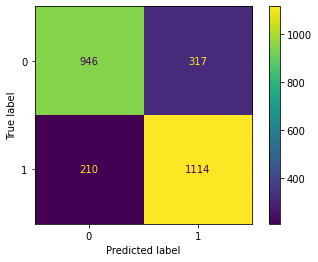

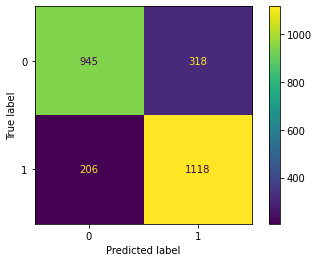

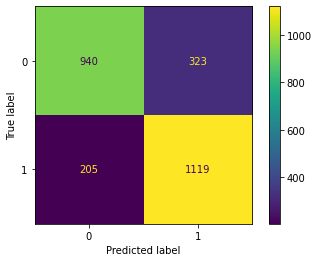

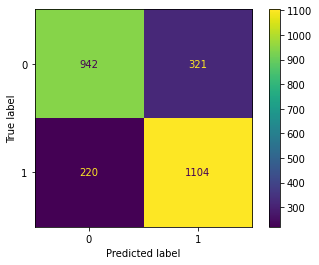

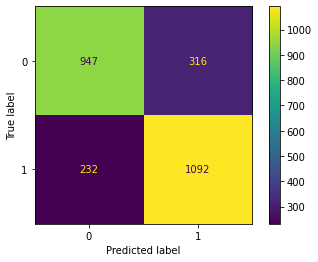

In [76]:
max_depth = list(range(10, 15))
for depth in max_depth:
  random_forest_model(df_oversmp, features, n_trees, depth)

Apesar de resultados de métricas próximas, a **profundidade 12 apresentou os melhores resultados** e, por isso, foi a escolhida. 

## Conclusão
As features selecionadas foram:

* 'gasto_mensal', 
* 'maior_65_anos', 
* 'genero',
* 'meses_contrato', 
* 'possui_dependentes', 
* 'plano_contratado'.

A quantidade de árvores se manteve no padrão da função no sklearn (100).

A profundidade escolhida (max_depth) foi 12.

Os resultados obtidos com essa seleção foram:
* Acurácia:  0.7893
* Precisão:  0.7648
* Recall:  0.8497
* F1:  0.8050

# Teste: previsão da base

Por fim, feitos os ajustes para otimização do modelo, irei aplicá-lo à própria base e ver como ele se sai na previsão da variável target.

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.8303279852335652
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.6287242169595111
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.8806848582129481
F1 (média harmônica precisão e recall):  0.7336750612881657


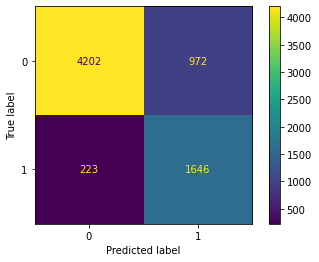

In [77]:
# treinando o modelo com a base, os parâmetros e as features selecionados
features = ['gasto_mensal', 'maior_65_anos', 'genero', 'meses_contrato', 'possui_dependentes', 'plano_contratado']
X_train, X_test, y_train, y_test = get_training_data(df_oversmp, features)
rf = RandomForestClassifier(random_state=SEED, n_estimators=100, max_depth=12)
rf.fit(X_train, y_train)

# predizendo os valores da base original (com label encoding)
y = df_encoded['cancelou_plano']
X = df_encoded[features] 
y_pred = rf.predict(X)

# print das métricas e matriz de confusão
get_metrics(y, y_pred)

In [78]:
# valores originais X valores previstos
print(y.value_counts())

# como visto em https://stackoverflow.com/questions/10741346/numpy-most-efficient-frequency-counts-for-unique-values-in-an-array
unique, counts = np.unique(y_pred, return_counts=True)
print(np.asarray((unique, counts)).T)

0    5174
1    1869
Name: cancelou_plano, dtype: int64
[[   0 4425]
 [   1 2618]]


Os resultados não foram muito satisfatórios... A precisão caiu bastante, consequentemente o F1 também caiu. Com isso, o modelo acertou mais os casos de clientes que cancelaram o plano, mas errou bastante nos clientes que não cancelaram o plano, identificando-os erroneamente como planos cancelados (os falsos positivos). 

Ou seja, **acabei criando um modelo pessimista**...

Meus conhecimentos de Machine Learning ainda são muito incipientes para eu fazer uma análise mais profunda do que pode ter acontecido, além de haver sempre a possibilidade de eu ter errado alguma coisa no código. Ficará para o futuro, quando eu tiver mais experiência em Data Science, retornar a este desafio e tentar melhorar este modelo.